# Generative Latent Implicit Conditional Optimization when Learning from Small Sample - Replication project
(Machine Learning 2021 Course project)

Imports:


In [13]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as torch_data
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from collections import defaultdict
from tqdm import trange



## 1.Implement GLICO

Model consists of 3 parts ( Network-Z, Generator, Classifier). <br>
Network-Z  ---> Maps each image $x_{i}$ from image space to vector $z_{i}$ in the latent space <br> 
Genterator ---> Takes the $z_{i}$ vector concatenated with noise vector $\varepsilon$ generating reconstructed image $\hat{x}$ <br>
Classifier ---> Generated image $\hat{x}$together with label $y_{i}$ trains a week classifier

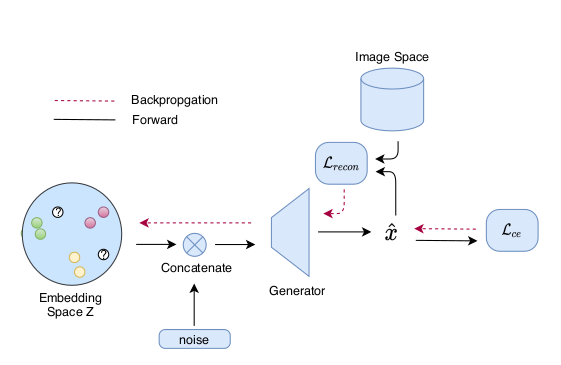

In [4]:
class netZ(nn.Module):
	def __init__(self, dic_size, vec_siz):
		super(netZ, self).__init__()
		self.dic_size = dic_size
		self.vec_siz = vec_siz
		self.emb = nn.Embedding(self.dic_size, self.vec_siz)

	def forward(self, x):
		z = self.emb(x).squeeze()
		return z

### Generator (DCGAN archetichture)

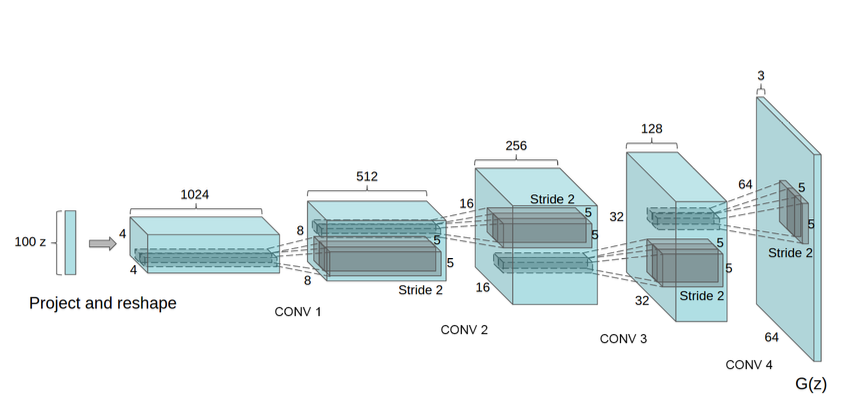

DCGAN architecture is a fully convolutional network.
All of the operations will be through strided convolutions only.
We will use the ReLU activation function in all the layers of the generator, except for the last one. For the last convolutional layer, we will use Tanh activation function.

In [5]:
class Generator(nn.Module):
	def __init__(self, z_dim, img_size, n_channels, noise=False, noise_projection=False):
		super(Generator, self).__init__()
		self.noise_projection = noise_projection
		self.dim_im = 512 * (img_size // 8) * (img_size // 8)
		projection_size = 100
		self.input_dim = z_dim
		self.noise = noise
		if noise:
			self.input_dim += projection_size
		self.lin_code = nn.Linear(100, projection_size, bias=False)
		self.lin_in = nn.Linear(self.input_dim, 1024, bias=False)
		self.lin_im = nn.Linear(1024, self.dim_im, bias=False)

		self.conv1 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=True)
		self.bn_conv1 = nn.BatchNorm2d(256)

		self.conv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=True)
		self.bn_conv2 = nn.BatchNorm2d(128)

		self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True)
		self.bn_conv3 = nn.BatchNorm2d(64)

		self.conv4 = nn.ConvTranspose2d(64, n_channels, 4, 2, 1, bias=True)
		self.bn_conv4 = nn.BatchNorm2d(n_channels)

		self.tanh = nn.Tanh()
		self.relu = nn.LeakyReLU(inplace=True)


	def forward(self, z, code):
		zn = z.norm(2, 1).detach().unsqueeze(1).expand_as(z)
		z = z.div(zn)
		if self.noise_projection:
			code = self.lin_code(code)
			code = self.relu(code)
		if self.noise:
			z = torch.cat((z.view(z.size(0), -1), code), -1)
		z = self.lin_in(z)
		print(z.shape)
		z = self.relu(z)
		z = self.lin_im(z)
		print(z.shape)
		z = self.relu(z)
		z = z.view(-1, 512, self.sz // 8, self.sz // 8)

		z = self.conv1(z)
		z = self.bn_conv1(z)
		z = self.relu(z)

		z = self.conv2(z)
		z = self.bn_conv2(z)
		z = self.relu(z)

		z = self.conv3(z)
		z = self.bn_conv3(z)
		z = self.relu(z)

		z = self.conv4(z)
		z = self.bn_conv4(z)
		output = self.tanh(z)

		return output

A week classifier is used in the paper consisting of small CNN with 4 convolutional layers.

In [6]:
class Classifier(nn.Module):
	def __init__(self, num_classes, dim=64, im_size=32):
		super(Classifier, self).__init__()
		self.n_filters = dim
		ds_size = im_size // 2 ** 4

		self.layer1 = nn.Sequential(nn.Conv2d(3, self.n_filters, kernel_size=3, stride=1, padding=1, bias=True),
	                              nn.BatchNorm2d(self.n_filters), nn.LeakyReLU(True),
	                              nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False))
		self.lrelu = nn.LeakyReLU(0.1)
		self.layer2 = nn.Sequential(nn.Conv2d(self.n_filters, self.n_filters, kernel_size=3, stride=1, padding=1, bias=True),
	                              nn.BatchNorm2d(self.n_filters), nn.LeakyReLU(True),
	                              nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False))
		self.layer3 = nn.Sequential(nn.Conv2d(self.n_filters, self.n_filters, kernel_size=3, stride=1, padding=1, bias=True),
	                              nn.BatchNorm2d(self.n_filters), nn.LeakyReLU(True),
	                              nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False))
		self.layer4 = nn.Sequential(nn.Conv2d(self.n_filters, self.n_filters, kernel_size=3, stride=1, padding=1, bias=True),
	                              nn.BatchNorm2d(self.n_filters), nn.LeakyReLU(True),
	                              nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False))
		self.out = nn.Linear(self.n_filters * ds_size ** 2, num_classes)
		self.softmax = nn.Softmax()



	def forward(self, x):
		x = self.layer1(x)
		x = self.lrelu(x)

		x = self.layer2(x)
		x = self.lrelu(x)

		x = self.layer3(x)
		x = self.lrelu(x)

		x = self.layer4(x)
		x = self.lrelu(x)

		x = x.view(x.size(0), -1)
		x = self.out(x)
		output = self.softmax(x)
		return output

In [17]:
class GLICO(nn.Module):
	def __init__(self, netZ, Generator, Classifier,noise=False):
		super(GLICO, self).__init__()
		self.netZ = netZ
		self.Generator = Generator
		self.Classifier = Classifier
		self.noise = noise

	def forward(self,xi,code):
		zi = self.netZ(xi)
		if self.noise == 'True':
			shape = zi.size()
			stddev = np.random.uniform(0 / 255.0, 50 / 255.0, size=shape)
			noise = torch.randn_like(zi).float()
			zi= zi + noise * torch.tensor(train_stddev).float()
   
			x_hat = self.Generator(zi, code)
		else:
			x_hat = self.Generator(zi, code)
		return x_hat
    

## 2. Replication of results on one of the datasets ( CIFAR-100)


Import the CIFAR-100 data set split it to train / val / test and create n labeled samples per class for training. n is a small number of data 10 for example.

In [7]:
base_dataset = torchvision.datasets.CIFAR100(root='./cifar_labeled', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./cifar_unlabeled', train=False, download=True)
X_train, X_val, y_train, y_val = train_test_split(base_dataset.data, base_dataset.targets, test_size=0.2)


Extracting ./cifar_labeled/cifar-100-python.tar.gz to ./cifar_labeled



Extracting ./cifar_unlabeled/cifar-100-python.tar.gz to ./cifar_unlabeled


In [8]:
#total data points per class = 5000
n_labeled_per_class= 10
n_unlabled_per_class= 4990

labels=np.array(y_train)
train_labeled_idxs = []
train_unlabeled_idxs = []

for i in range(10):  #n_classes = 10
  idxs = np.where(labels == i)[0]
  np.random.shuffle(idxs)
  train_labeled_idxs.extend(idxs[:n_labeled_per_class])
  train_unlabeled_idxs.extend(idxs[n_labeled_per_class:])
np.random.shuffle(train_labeled_idxs)
np.random.shuffle(train_unlabeled_idxs)

In [10]:
X_train_labeled, y_train_labeled = X_train[train_labeled_idxs], np.array(y_train)[train_labeled_idxs]

In [11]:
class CIFARDataset(torch_data.Dataset):
	def __init__(self, X, y ):
		super(CIFARDataset, self).__init__()
		self.X = torch.tensor(X, dtype=torch.long)
		self.y = torch.tensor(y, dtype=torch.long)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		return self.X[idx], self.y[idx]

In [16]:
# transform=torchvision.transforms.Compose([transforms.ToPILImage(),
# 			  	                                transforms.RandomCrop(32, padding=4),
# 				                                  transforms.RandomHorizontalFlip(p=0.5)])
train_dataset=CIFARDataset(X_train_labeled,y_train_labeled)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True) 

val_dataset=CIFARDataset(X_val,y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=False) 

Intiate the model and hyperparameters.

In [19]:
Z = netZ(10000,1024)
G = Generator(100,32,100,noise=False)
C = Classifier(100)
Model = GLICO(Z,G,C)
batch_size= 50
lr= 1e-3
epochs= 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerZ = torch.optim.Adam(Z.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerC = torch.optim.SGD( C.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizerC, milestones=[60, 120, 160 ], gamma=0.2)
d_criterion = nn.CrossEntropyLoss()

In [20]:
def train(Model, optimizerG,optimizerZ,optimizerC,loss_function, train_dataloader, val_dataloader, device, epochs_n=1, scheduler=None):
    model = Model.to(device)
    for epoch in trange(epochs_n):
        model.train()
        losess=[]
        for model_input, target in train_dataloader:
            print(model_input.shape)
            model_input = model_input.to(device)
            target = target.to(device)
            model_output = model(model_input, 0)
            loss = loss_function(model_output, target)
      
            optimizerZ.zero_grad()
            optimizerG.zero_grad()
            optimizerD.zero_grad()

            loss.backward()

            optimizerZ.step()
            optimizerG.step()
            optimizerC.step()

            losses.append(loss)
        return losses
        
        scheduler.step()      

In [ ]:
train(Model, optimizerG ,optimizerZ ,optimizerC ,d_criterion, train_dataloader, val_dataloader, device, 5, 1, scheduler)

### Expirment 1


Expermint with Autoaugment and cut-out:
Two classes below are taken from orginal repositry 
-experminet was not finished because training in the previous step failed-

In [ ]:
import random
import numpy as np
import scipy
import torch
from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps


class AutoAugment(object):
	def __init__(self):
		self.policies = [
				['Invert', 0.1, 7, 'Contrast', 0.2, 6],
				['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
				['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
				['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
				['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
				['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
				['Color', 0.4, 3, 'Brightness', 0.6, 7],
				['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
				['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
				['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
				['Color', 0.7, 7, 'TranslateX', 0.5, 8],
				['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
				['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
				['Brightness', 0.9, 6, 'Color', 0.2, 8],
				['Solarize', 0.5, 2, 'Invert', 0, 0.3],
				['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
				['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
				['Color', 0.9, 9, 'Equalize', 0.6, 6],
				['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
				['Brightness', 0.1, 3, 'Color', 0.7, 0],
				['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
				['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
				['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
				['Equalize', 0.8, 8, 'Invert', 0.1, 3],
				['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
				]

	def __call__(self, img):
		img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
		return img


operations = {
		'ShearX': lambda img, magnitude: shear_x(img, magnitude),
		'ShearY': lambda img, magnitude: shear_y(img, magnitude),
		'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
		'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
		'Rotate': lambda img, magnitude: rotate(img, magnitude),
		'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
		'Invert': lambda img, magnitude: invert(img, magnitude),
		'Equalize': lambda img, magnitude: equalize(img, magnitude),
		'Solarize': lambda img, magnitude: solarize(img, magnitude),
		'Posterize': lambda img, magnitude: posterize(img, magnitude),
		'Contrast': lambda img, magnitude: contrast(img, magnitude),
		'Color': lambda img, magnitude: color(img, magnitude),
		'Brightness': lambda img, magnitude: brightness(img, magnitude),
		'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
		'Cutout': lambda img, magnitude: cutout(img, magnitude),
		}


def apply_policy(img, policy):
	if random.random() < policy[1]:
		img = operations[policy[0]](img, policy[2])
	if random.random() < policy[4]:
		img = operations[policy[3]](img, policy[5])

	return img


def transform_matrix_offset_center(matrix, x, y):
	o_x = float(x) / 2 + 0.5
	o_y = float(y) / 2 + 0.5
	offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
	reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
	transform_matrix = offset_matrix @ matrix @ reset_matrix
	return transform_matrix


def shear_x(img, magnitude):
	img = np.array(img)
	magnitudes = np.linspace(-0.3, 0.3, 11)

	transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
	                             [0, 1, 0],
	                             [0, 0, 1]])
	transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
	affine_matrix = transform_matrix[:2, :2]
	offset = transform_matrix[:2, 2]
	img = np.stack([ndimage.interpolation.affine_transform(
			img[:, :, c],
			affine_matrix,
			offset) for c in range(img.shape[2])], axis=2)
	img = Image.fromarray(img)
	return img


def shear_y(img, magnitude):
	img = np.array(img)
	magnitudes = np.linspace(-0.3, 0.3, 11)

	transform_matrix = np.array([[1, 0, 0],
	                             [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
	                             [0, 0, 1]])
	transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
	affine_matrix = transform_matrix[:2, :2]
	offset = transform_matrix[:2, 2]
	img = np.stack([ndimage.interpolation.affine_transform(
			img[:, :, c],
			affine_matrix,
			offset) for c in range(img.shape[2])], axis=2)
	img = Image.fromarray(img)
	return img


def translate_x(img, magnitude):
	img = np.array(img)
	magnitudes = np.linspace(-150/331, 150/331, 11)

	transform_matrix = np.array([[1, 0, 0],
	                             [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
	                             [0, 0, 1]])
	transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
	affine_matrix = transform_matrix[:2, :2]
	offset = transform_matrix[:2, 2]
	img = np.stack([ndimage.interpolation.affine_transform(
			img[:, :, c],
			affine_matrix,
			offset) for c in range(img.shape[2])], axis=2)
	img = Image.fromarray(img)
	return img


def translate_y(img, magnitude):
	img = np.array(img)
	magnitudes = np.linspace(-150/331, 150/331, 11)

	transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
	                             [0, 1, 0],
	                             [0, 0, 1]])
	transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
	affine_matrix = transform_matrix[:2, :2]
	offset = transform_matrix[:2, 2]
	img = np.stack([ndimage.interpolation.affine_transform(
			img[:, :, c],
			affine_matrix,
			offset) for c in range(img.shape[2])], axis=2)
	img = Image.fromarray(img)
	return img


def rotate(img, magnitude):
	img = np.array(img)
	magnitudes = np.linspace(-30, 30, 11)
	theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
	                             [np.sin(theta), np.cos(theta), 0],
	                             [0, 0, 1]])
	transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
	affine_matrix = transform_matrix[:2, :2]
	offset = transform_matrix[:2, 2]
	img = np.stack([ndimage.interpolation.affine_transform(
			img[:, :, c],
			affine_matrix,
			offset) for c in range(img.shape[2])], axis=2)
	img = Image.fromarray(img)
	return img


def auto_contrast(img, magnitude):
	img = ImageOps.autocontrast(img)
	return img


def invert(img, magnitude):
	img = ImageOps.invert(img)
	return img


def equalize(img, magnitude):
	img = ImageOps.equalize(img)
	return img


def solarize(img, magnitude):
	magnitudes = np.linspace(0, 256, 11)
	img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	return img


def posterize(img, magnitude):
	magnitudes = np.linspace(4, 8, 11)
	img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
	return img


def contrast(img, magnitude):
	magnitudes = np.linspace(0.1, 1.9, 11)
	img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	return img


def color(img, magnitude):
	magnitudes = np.linspace(0.1, 1.9, 11)
	img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	return img


def brightness(img, magnitude):
	magnitudes = np.linspace(0.1, 1.9, 11)
	img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	return img


def sharpness(img, magnitude):
	magnitudes = np.linspace(0.1, 1.9, 11)
	img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
	return img


def cutout(org_img, magnitude=None):
	img = np.array(img)

	magnitudes = np.linspace(0, 60/331, 11)

	img = np.copy(org_img)
	mask_val = img.mean()

	if magnitude is None:
		mask_size = 16
	else:
		mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
	top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
	left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
	bottom = top + mask_size
	right = left + mask_size

	if top < 0:
		top = 0
	if left < 0:
		left = 0

	img[top:bottom, left:right, :].fill(mask_val)

	img = Image.fromarray(img)

	return img



class Cutout_(object):
	def __init__(self, length=5):
		self.length = length

	def __call__(self, img):
		img = np.array(img)

		mask_val = img.mean()

		top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
		left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
		bottom = top + self.length
		right = left + self.length

		top = 0 if top < 0 else top
		left = 0 if left < 0 else top

		img[top:bottom, left:right, :] = mask_val

		img = Image.fromarray(img)

		return img